In [58]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [59]:
def k(x,y):
    #return np.exp(-0.5*np.linalg.norm(x-y)**2)
    return np.exp(-0.5*np.sum(x-y)**2)

In [60]:
def Gram_Matrix(X):
    pairwise_dist=squareform(pdist(X,'euclidean'))
    K=np.exp(-0.5*pairwise_dist**2)
    return K

In [61]:
X=np.random.normal(size=(10000,1))
Y=np.random.normal(size=(10000,1))
Y_2=2*X
print(X)
print(Y)
print(Y_2)
sinX = np.sin(X)

[[ 0.1403518 ]
 [ 0.61094596]
 [-1.2021441 ]
 ...
 [ 0.25002102]
 [ 0.69861538]
 [ 0.64704338]]
[[-2.26971779]
 [-0.32878927]
 [-1.54805572]
 ...
 [-0.65784901]
 [-1.7784155 ]
 [-0.38204322]]
[[ 0.28070359]
 [ 1.22189193]
 [-2.4042882 ]
 ...
 [ 0.50004205]
 [ 1.39723075]
 [ 1.29408677]]


In [62]:
Gram_Matrix(X)

array([[1.        , 0.89518092, 0.40610334, ..., 0.99400438, 0.85570541,
        0.87952949],
       [0.89518092, 1.        , 0.19327373, ..., 0.93694246, 0.99616441,
        0.9993487 ],
       [0.40610334, 0.19327373, 1.        , ..., 0.34840427, 0.16423724,
        0.18091152],
       ...,
       [0.99400438, 0.93694246, 0.34840427, ..., 1.        , 0.904278  ,
        0.92421239],
       [0.85570541, 0.99616441, 0.16423724, ..., 0.904278  , 1.        ,
        0.99867105],
       [0.87952949, 0.9993487 , 0.18091152, ..., 0.92421239, 0.99867105,
        1.        ]])

In [63]:
k(X,X)

1.0

In [64]:
def HSIC(X,Y):
    # Firt calculate the gram matices for the X and Y data
    K_x= Gram_Matrix(X)
    K_y=Gram_Matrix(Y)
    
    m=X.shape[0]
    H = np.identity(m)-1/m
    
    K_yH=np.matmul(K_y,H)
    HK_yH=np.matmul(H,K_yH)
    K_xHK_yH=np.matmul(K_x,HK_yH)
    
    hsic=(m-1)**(-2)*np.trace(K_xHK_yH)
    
    return hsic

In [65]:
print(HSIC(X,Y))

7.426319071289261e-06


In [66]:
print(HSIC(X,Y_2))

0.07635597398136489


In [67]:
print(HSIC(X,X))

0.07302392897854697


In [68]:
print(HSIC(X,sinX))

0.05907895213329362


In [69]:
2**3

8

In [70]:
3**2

9

In [71]:
m=3
print(np.identity(m))
print(1/m)
np.identity(m)-1/m

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.3333333333333333


array([[ 0.66666667, -0.33333333, -0.33333333],
       [-0.33333333,  0.66666667, -0.33333333],
       [-0.33333333, -0.33333333,  0.66666667]])

In [72]:
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12

Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).

Shoubo (shoubo.sub AT gmail.com)
09/11/2016

Inputs:
X         n by dim_x matrix
Y         n by dim_y matrix
alph         level of test

Outputs:
testStat    test statistics
thresh        test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
    size1 = pattern1.shape
    size2 = pattern2.shape

    G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)

    Q = np.tile(G, (1, size2[0]))
    R = np.tile(H.T, (size1[0], 1))

    H = Q + R - 2* np.dot(pattern1, pattern2.T)

    H = np.exp(-H/2/(deg**2))

    return H


def hsic_gam(X, Y, alph = 0.5):
    """
    X, Y are numpy vectors with row - sample, col - dim
    alph is the significance level
    auto choose median to be the kernel width
    """
    n = X.shape[0]

    # ----- width of X -----
    Xmed = X

    G = np.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )

    dists = Q + R - 2* np.dot(Xmed, Xmed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)

    width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----

    # ----- width of X -----
    Ymed = Y

    G = np.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )

    dists = Q + R - 2* np.dot(Ymed, Ymed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)

    width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----

    bone = np.ones((n, 1), dtype = float)
    H = np.identity(n) - np.ones((n,n), dtype = float) / n

    K = rbf_dot(X, X, width_x)
    L = rbf_dot(Y, Y, width_y)

    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)

    testStat = np.sum(Kc.T * Lc) / n

    varHSIC = (Kc * Lc / 6)**2

    varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)

    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)

    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L))

    muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
    muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)

    mHSIC = (1 + muX * muY - muX - muY) / n

    al = mHSIC**2 / varHSIC
    bet = varHSIC*n / mHSIC

    thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]

    return (testStat, thresh)


In [73]:
hsic_gam(X.reshape(len(X), 1), Y.reshape(len(Y), 1))

(0.1903333274750292, 0.3047392764853827)

In [74]:
0.39944397757622274/0.3047480097802441

1.31073531165721

In [75]:
A=[1,1,1,2,2,2,3,3,3]
print(A)
np.tile(A, 3)

[1, 1, 1, 2, 2, 2, 3, 3, 3]


array([1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1, 1, 2,
       2, 2, 3, 3, 3])

In [76]:
np.sum(A*A, 1)

TypeError: can't multiply sequence by non-int of type 'list'

Text(0, 0.5, 'x7')

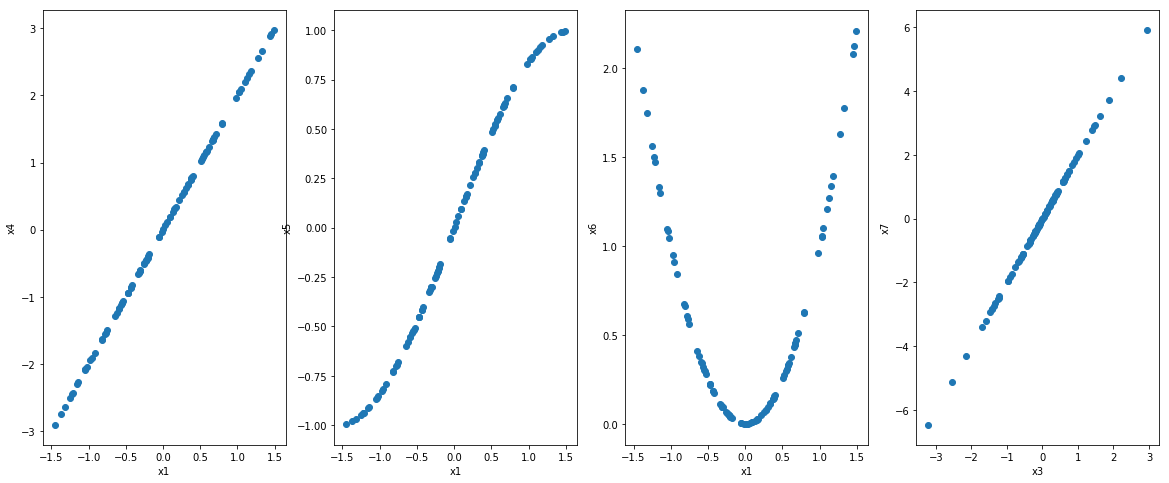

In [87]:
import numpy as np
import csv
import pandas as pd

size = 100
np.random.seed(123)
x1 = np.random.uniform(size=size, low=-1.5, high=1.5)
x2 = np.random.laplace(size=size)
x3 = np.random.normal(0,1, size=size)
x4 = 2*x1
x5 = np.sin(x1)
x6 = np.power(x1,2)
x7 = x3+x3

xs = np.array([x1,x2,x3,x4,x5,x6, x7]).T

X = pd.DataFrame(np.array([x1, x2, x3,x4,x5,x6,x7]).T,columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7"])
X.head()
X.to_csv('HSIC_test.csv', index=False)

#import matplotlib.pyplot as plt
#plt.hist(x1, bins=100)
#plt.hist(x2, bins=100)
#plt.hist(x3, bins=100)
#plt.hist(x4, bins=100)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,8))
plt1 = fig.add_subplot(1, 4, 1)
plt2 = fig.add_subplot(1, 4, 2)
plt3 = fig.add_subplot(1, 4, 3)
plt4 = fig.add_subplot(1, 4, 4)
#plt5 = fig.add_subplot(1, 5, 5)

plt1.scatter(x1[1:300], x4[1:300])
plt1.set_xlabel('x1')
plt1.set_ylabel('x4')

plt2.scatter(x1[1:300], x5[1:300])
plt2.set_xlabel('x1')
plt2.set_ylabel('x5')

plt3.scatter(x1[1:300], x6[1:300])
plt3.set_xlabel('x1')
plt3.set_ylabel('x6')

plt4.scatter(x3[1:300], x7[1:300])
plt4.set_xlabel('x3')
plt4.set_ylabel('x7')

In [88]:
print(HSIC(x1.reshape(size,1),x4.reshape(size,1)))
print(HSIC(x1.reshape(size,1),x5.reshape(size,1)))
print(HSIC(x1.reshape(size,1),x6.reshape(size,1)))
print(HSIC(x3.reshape(size,1),x7.reshape(size,1)))

0.0733025909550683
0.051922419850027185
0.013969032701374366
0.059147311617138855


In [89]:
print(HSIC(x1.reshape(size,1),x2.reshape(size,1)))
print(HSIC(x2.reshape(size,1),x3.reshape(size,1)))
print(HSIC(x1.reshape(size,1),x3.reshape(size,1)))

0.0008114332299933278
0.0031962155590183013
0.0011640889692776273
